<a href="https://colab.research.google.com/github/gursimarsm/pstl/blob/main/Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4586 sha256=bc0a4fc81221cc8e4d05f5e74930946f91b73104ebf3f6fb3cd858e79e6642e6
  Stored in directory: /root/.cache/pip/wheels/5d/12/ec/0fc50553af000b9c3d2c74b9f77a01ae4bfe856e9917ac239c
Successfully built rdp


{'trade': 'Sell', 'entry_point': 62.05, 'sl': 42.1, 'tg': 42.1, 'max_profit': 19.949999999999996}


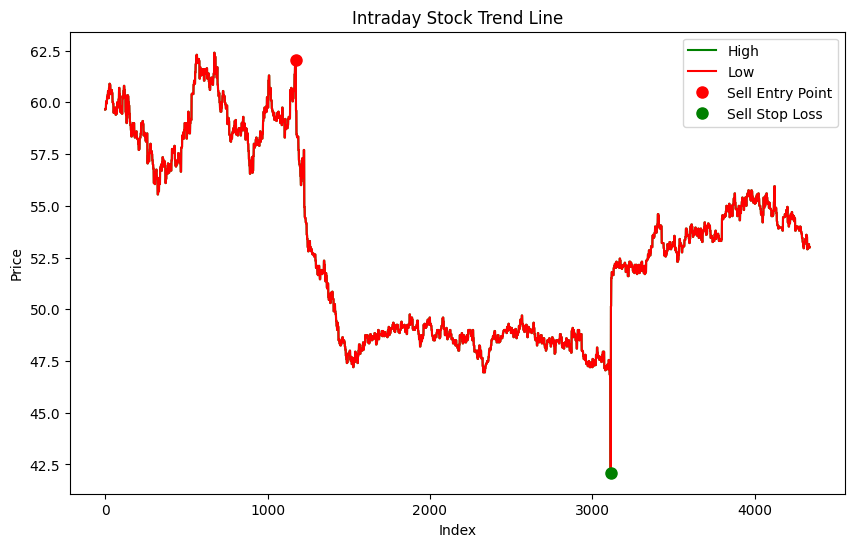

In [2]:
from rdp import rdp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_trend_line_rdp(data, retracement_threshold, min_retracement_pct, epsilon):
    best_tl = {'trade': None, 'entry_point': None, 'sl': None, 'tg': None, 'max_profit': 0}

    points = np.column_stack((np.arange(len(data)), data['low'].values))
    simplified_points = rdp(points, epsilon=epsilon)
    simplified_indices = simplified_points[:, 0].astype(int)

    for start_idx, end_idx in zip(simplified_indices[:-1], simplified_indices[1:]):
        current_data = data.iloc[start_idx:end_idx]

        tl_top = current_data['high'].max()
        tl_bottom = current_data['low'].min()

        retracement = (tl_top - tl_bottom) * min_retracement_pct / 100

        for i in range(end_idx, len(data)):
            if tl_top - data.iloc[i]['high'] > retracement:
                reversal_point = data.iloc[i]['high']
                if data.iloc[i]['low'] < tl_bottom:
                    trade = 'Sell'
                    sl = reversal_point
                    entry_point = tl_bottom
                    tg = entry_point - (entry_point - reversal_point)
                    profit = abs(tg - entry_point)

                    if profit > best_tl['max_profit']:
                        best_tl = {
                            'trade': trade,
                            'entry_point': entry_point,
                            'sl': sl,
                            'tg': tg,
                            'max_profit': profit,
                        }
            elif data.iloc[i]['low'] - tl_bottom > retracement:
                reversal_point = data.iloc[i]['low']
                if data.iloc[i]['high'] > tl_top:
                    trade = 'Buy'
                    sl = reversal_point
                    entry_point = tl_top
                    tg = entry_point + (entry_point - reversal_point)
                    profit = abs(tg - entry_point)

                    if profit > best_tl['max_profit']:
                        best_tl = {
                            'trade': trade,
                            'entry_point': entry_point,
                            'sl': sl,
                            'tg': tg,
                            'max_profit': profit,
                        }

    return best_tl

def plot_chart(data, result):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data.index, data['high'], label='High', color='green')
    ax.plot(data.index, data['low'], label='Low', color='red')

    if result['trade'] == 'Buy':
        entry_point_idx = data[data['high'] == result['entry_point']].index[0]
        sl_idx = data[data['low'] == result['sl']].index[0]

        ax.plot(entry_point_idx, result['entry_point'], 'go', label='Buy Entry Point', markersize=8)
        ax.plot(sl_idx, result['sl'], 'ro', label='Buy Stop Loss', markersize=8)
    elif result['trade'] == 'Sell':
        entry_point_idx = data[data['low'] == result['entry_point']].index[0]
        sl_idx = data[data['high'] == result['sl']].index[0]

        ax.plot(entry_point_idx, result['entry_point'], 'ro', label='Sell Entry Point', markersize=8)
        ax.plot(sl_idx, result['sl'], 'go', label='Sell Stop Loss', markersize=8)

    ax.set_xlabel('Index')
    ax.set_ylabel('Price')
    ax.set_title('Intraday Stock Trend Line')
    ax.legend()
    plt.show()

# Read the CSV file
filename = 'data.csv'
data = pd.read_csv(filename)

# Extract high and low prices
price_data = pd.DataFrame()
price_data['high'] = data['LTP']
price_data['low'] = data['LTP']

# Parameters
retracement_threshold = 10
min_retracement_pct = 5
epsilon = 1

# Execution
result = generate_trend_line_rdp(price_data, retracement_threshold, min_retracement_pct, epsilon)
print(result)

# Plot chart
plot_chart(price_data, result)